Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 10
Starting iteration 11
Starting iteration 12
Starting iteration 13
Starting iteration 14
Starting iteration 15
Starting iteration 16
Starting iteration 17
Starting iteration 18
Starting iteration 19
Starting iteration 20
Starting iteration 21
Starting iteration 22
Starting iteration 23
Starting iteration 24
Starting iteration 25
Starting iteration 26
Starting iteration 27
Starting iteration 28
Starting iteration 29
Starting iteration 30
Starting iteration 31
Starting iteration 32
Starting iteration 33
Starting iteration 34
Starting iteration 35
Starting iteration 36
Starting iteration 37
Starting iteration 38
Starting iteration 39
Starting iteration 40
Starting iteration 41
Starting iteration 42
Starting iteration 43
Starting iteration 44
Starting iteration 4

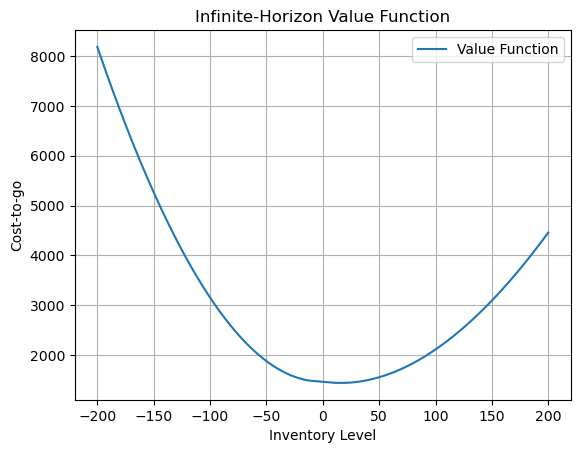

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class InfiniteHorizonValueIteration:
    def __init__(self, 
                 min_inventory, 
                 max_inventory, 
                 num_actions, 
                 discount, 
                 p,      # Procurement cost per unit
                 a_cost, # Holding cost coefficient
                 b_cost, # Backlog cost coefficient
                 demand_max):
        """
        Set up parameters for infinite-horizon inventory control.
        
        min_inventory, max_inventory: integer bounds on inventory level
        num_actions: how many discrete actions (0..num_actions-1 is how many units to order)
        discount: discount factor (1.0 for no discounting)
        p, a_cost, b_cost: cost parameters
        demand_max: demand is in {0..demand_max}, assumed uniform in this code
        """
        self.min_inventory = min_inventory
        self.max_inventory = max_inventory
        self.num_states = (max_inventory - min_inventory + 1)
        self.num_actions = num_actions
        self.discount = discount
        
        self.p = p
        self.a_cost = a_cost
        self.b_cost = b_cost
        self.demand_max = demand_max
        self.demand_prob = 1.0 / (demand_max + 1)
        
        # We'll store the final value function in self.V (1D array of length num_states)
        # and the final policy in self.policy (also length num_states).
        self.V = np.zeros(self.num_states)
        self.policy = np.zeros(self.num_states, dtype=int)
    
    def state_to_inventory(self, s_idx):
        """Convert state index to actual inventory level."""
        return s_idx + self.min_inventory
    
    def inventory_to_state(self, inv):
        """Convert actual inventory level to state index, clamped to [0..num_states-1]."""
        s_idx = inv - self.min_inventory
        s_idx = max(0, min(s_idx, self.num_states - 1))
        return s_idx
    
    def cost_function(self, s_idx, action):
        """
        Immediate cost if in state s_idx (inventory = state_to_inventory(s_idx))
        and we order 'action' units.
        
        Then the inventory after ordering (but before demand) is inv + action.
        We'll define cost purely as procurement + holding/backlog after we see the demand.
        But for the sake of the Bellman operator, we separate out the part that doesn't depend on demand:
        Actually, in a cost-minimization setting with random demand, we do:
        
           cost(s, a) + discount * E[ V(next_state) ].
        
        In many approaches, cost is computed after the demand is realized. 
        However, here we do a simpler approach: we'll compute the cost once we know the next state 
        in the loop, i.e. in the sum over demands. That means cost_function might just do the 
        procurement part. But let's keep it consistent with your previous code, 
        where cost includes p*a + holding/backlog of the new state. 
        We'll define that in the transition loop below.
        
        For now, let's return p*a as the "immediate cost of ordering," 
        and we add the holding/backlog in the transition sum.
        
        But if you prefer your original approach, you can do everything in the transition loop. 
        We'll keep it consistent with the code approach that you used in finite horizon. 
        So we might just return p*a here, and then in the next state cost we do the holding/backlog.
        """
        # For consistency with your prior code, let's return p*a here, 
        # then add holding/backlog cost after demand is realized.
        return self.p * action
    
    def holding_backlog_cost(self, inv):
        """
        Holding/backlog cost if the final inventory is inv (actual).
        If inv >= 0 => a_cost*inv, else => b_cost*(-inv).
        """
        if inv >= 0:
            return self.a_cost * inv
        else:
            return self.b_cost * (-inv)
    
    def run_value_iteration(self, max_iterations=1000, epsilon=1e-6):
        """
        Runs infinite-horizon value iteration with cost minimization until convergence or max_iterations.
        
        We'll store the final result in self.V and self.policy.
        
        Pseudocode for cost minimization:
        
          V_{n+1}(s) = min_a [ immediate_cost(s,a) + discount * sum_w P(w) [ holding_backlog_cost(...) + V_n( next_state ) ] ]
        
        We'll do a loop until max_{s} |V_{n+1}(s) - V_n(s)| < epsilon or we hit max_iterations.
        """
        # Initialize V to zeros (already done in __init__)
        
        for iteration in range(max_iterations):
            print(f"Starting iteration {iteration}")
            V_new = np.zeros_like(self.V)
            # We'll store Q(s,a) in a local array for each s. Then we pick the min over a.
            
            for s_idx in range(self.num_states):
                inv = self.state_to_inventory(s_idx)
                # We'll compute Q(s_idx, a) for each action a
                Q_sa = np.zeros(self.num_actions)
                
                for a in range(self.num_actions):
                    # immediate ordering cost
                    cost_order = self.cost_function(s_idx, a)
                    # Then we sum over demands w in {0..demand_max}
                    expected_future = 0.0
                    for w in range(self.demand_max + 1):
                        w_prob = self.demand_prob
                        new_inv = inv + a - w
                        # clamp new_inv
                        new_inv = max(self.min_inventory, min(new_inv, self.max_inventory))
                        # next state index
                        s_next_idx = self.inventory_to_state(new_inv)
                        
                        # holding/backlog cost
                        cost_hold = self.holding_backlog_cost(new_inv)
                        
                        # total immediate cost for this transition
                        immediate_cost = cost_order + cost_hold
                        
                        # add discounted future cost
                        expected_future += w_prob * ( immediate_cost + self.discount * self.V[s_next_idx] )
                    
                    Q_sa[a] = expected_future
                
                # pick the action that yields minimal cost
                best_a = np.argmin(Q_sa)
                V_new[s_idx] = Q_sa[best_a]
            
            # check convergence
            diff = np.max(np.abs(V_new - self.V))
            self.V = V_new
            if diff < epsilon:
                print(f"Converged at iteration {iteration} with diff={diff:.4f}")
                break
        if iteration == max_iterations - 1:
            print(f"Warning: Did not converge after {max_iterations} iterations.")
        
        # After finishing, we extract the policy
        for s_idx in range(self.num_states):
            inv = self.state_to_inventory(s_idx)
            # compute Q_sa again to find the best action
            Q_sa = np.zeros(self.num_actions)
            for a in range(self.num_actions):
                cost_order = self.p * a
                expected_future = 0.0
                for w in range(self.demand_max + 1):
                    new_inv = inv + a - w
                    new_inv = max(self.min_inventory, min(new_inv, self.max_inventory))
                    s_next_idx = self.inventory_to_state(new_inv)
                    cost_hold = self.holding_backlog_cost(new_inv)
                    immediate_cost = cost_order + cost_hold
                    expected_future += self.demand_prob * ( immediate_cost + self.discount*self.V[s_next_idx] )
                Q_sa[a] = expected_future
            best_a = np.argmin(Q_sa)
            self.policy[s_idx] = best_a
    
    def get_action(self, inv):
        """
        Given an inventory level inv (actual), return the action from the final policy.
        """
        s_idx = self.inventory_to_state(inv)
        return self.policy[s_idx]


########################################
# Example usage
########################################
if __name__ == "__main__":
    # Example parameters
    min_inv = -200
    max_inv = 200
    num_actions = 20
    discount = 0.99
    p = 2
    a_cost = 1
    b_cost = 5
    demand_max = 10
    
    # Instantiate the infinite horizon VI
    vi = InfiniteHorizonValueIteration(min_inventory=min_inv,
                                       max_inventory=max_inv,
                                       num_actions=num_actions,
                                       discount=discount,
                                       p=p,
                                       a_cost=a_cost,
                                       b_cost=b_cost,
                                       demand_max=demand_max)
    
    # Run value iteration
    vi.run_value_iteration(max_iterations=5000, epsilon=1e-6)
    
    # The final V array is in vi.V, and the final policy is in vi.policy.
    print("Final Value Function shape:", vi.V.shape)
    print("Sample of final policy for first 10 states:", vi.policy[:10])
    
    # Example: Print best action for inventory in [0..5]
    for inv in range(0,6):
        a_star = vi.get_action(inv)
        print(f"Inventory {inv}, best action = {a_star}")
    
    # If you want to plot the value function vs. inventory, do:
    inventory_levels = np.arange(min_inv, max_inv+1)
    plt.figure()
    plt.plot(inventory_levels, vi.V, label="Value Function")
    plt.xlabel("Inventory Level")
    plt.ylabel("Cost-to-go")
    plt.title("Infinite-Horizon Value Function")
    plt.grid(True)
    plt.legend()
    plt.show()


In [18]:
print(np.argmin(vi.V))

216


In [19]:
print(vi.V[0])

22766.880117882756


19736.493221915047


In [28]:

import numpy as np

def compute_infinite_base_stock_level(V, 
                                      min_inventory, 
                                      max_inventory,
                                      demand_values, 
                                      demand_prob, 
                                      holding_cost, 
                                      discount, 
                                      price, 
                                      s=0):
    """
    Computes the single base-stock level sigma for an infinite-horizon inventory model,
    given the infinite-horizon value function V (shape: [num_states]).
    
    We solve (for cost-minimization):
      sigma = argmin_{z >= s} { price*(z - s) + E[ holding_cost(z - W) + discount*V[z - W] ] },
    where z - W is clamped to [min_inventory..max_inventory].
    
    Parameters:
      V: 1D numpy array of shape (num_states,) from infinite-horizon value iteration
         (no time dimension).
      min_inventory, max_inventory: define the mapping state_index -> actual_inventory
      demand_values: list or array of possible demands
      demand_prob: function or array of probabilities for each demand in demand_values,
                   or a single float if uniform
      holding_cost: a function that returns holding/backlog cost for an inventory level
      discount: discount factor (e.g., 1.0 for no discounting)
      price: per-unit procurement cost p
      s: the pre-decision inventory level (actual), so we only consider z >= s.
    
    Returns:
      best_z: the single base-stock level (actual inventory) that minimizes the infinite-horizon cost.
    """
    num_states = max_inventory - min_inventory + 1
    best_cost = float('inf')
    best_z = None
    
    for z_index in range(num_states):
        z = z_index + min_inventory
        if z >= s:
            # Compute the expected cost for choosing z
            #  cost(z) = price*(z - s) + E[holding_cost(z - w) + discount*V[z-w]]
            order_cost = price * (z - s) if z > s else 0.0
            cost_sum = 0.0
            for w in demand_values:
                if isinstance(demand_prob, float):
                    # uniform distribution
                    prob_w = demand_prob
                else:
                    # demand_prob is an array of probabilities
                    prob_w = demand_prob[w]
                
                new_inventory = z - w
                # clamp to [min_inventory..max_inventory]
                if new_inventory < min_inventory:
                    new_inventory = min_inventory
                elif new_inventory > max_inventory:
                    new_inventory = max_inventory
                
                # holding/backlog cost
                cost_hold = holding_cost(new_inventory)
                
                # next state index
                s_next_index = new_inventory - min_inventory
                # infinite-horizon cost-to-go from V
                future_cost = V[s_next_index]
                
                cost_sum += prob_w * (cost_hold + discount * future_cost)
            
            total_cost = order_cost + cost_sum
            
            if total_cost < best_cost:
                best_cost = total_cost
                best_z = z
    
    return best_z

########################################
# Example usage
########################################
if __name__ == "__main__":
    # Suppose you have already run infinite-horizon value iteration
    # and obtained an array V of shape (num_states,).
    # For demonstration, we create a dummy V:
    min_inv = -200
    max_inv = 200
    num_states = max_inv - min_inv + 1
    V_infinite = vi.V # Replace with your actual V from infinite-horizon VI
    
    # Suppose demand_values = [0..10], uniform => prob=1/11 each
    demand_values = np.arange(0, 11)
    demand_prob = 1.0 / len(demand_values)
    
    # Define a holding cost function
    def holding_cost(x):
        a_cost = 1
        b_cost = 5
        if x >= 0:
            return a_cost * x
        else:
            return b_cost * (-x)
    
    discount = 0.99
    price = 2
    s_initial = 0  # We want a base-stock threshold for pre-decision inventory s=0
    
    # Compute the infinite-horizon base-stock level
    sigma = compute_infinite_base_stock_level(V_infinite,
                                              min_inv,
                                              max_inv,
                                              demand_values,
                                              demand_prob,
                                              holding_cost,
                                              discount,
                                              price,
                                              s=s_initial)
    
    print("Infinite-horizon base-stock level (actual inventory) =", sigma)


Infinite-horizon base-stock level (actual inventory) = 9


In [29]:
for state in range(min_inv, max_inv+1):
    print(f"State {state}, best action = {vi.get_action(state)}")

State -200, best action = 19
State -199, best action = 19
State -198, best action = 19
State -197, best action = 19
State -196, best action = 19
State -195, best action = 19
State -194, best action = 19
State -193, best action = 19
State -192, best action = 19
State -191, best action = 19
State -190, best action = 19
State -189, best action = 19
State -188, best action = 19
State -187, best action = 19
State -186, best action = 19
State -185, best action = 19
State -184, best action = 19
State -183, best action = 19
State -182, best action = 19
State -181, best action = 19
State -180, best action = 19
State -179, best action = 19
State -178, best action = 19
State -177, best action = 19
State -176, best action = 19
State -175, best action = 19
State -174, best action = 19
State -173, best action = 19
State -172, best action = 19
State -171, best action = 19
State -170, best action = 19
State -169, best action = 19
State -168, best action = 19
State -167, best action = 19
State -166, be

Time | Inventory |  Base-Stock (sigma) | Demand | Action
-----------------------------------------------------------
   0 |         0 |                  9 |      0 |      9
   1 |         9 |                  9 |      2 |      0
   2 |         7 |                  9 |      6 |      2
   3 |         3 |                  9 |      5 |      6
   4 |         4 |                  9 |      9 |      5
   5 |         0 |                  9 |      6 |      9
   6 |         3 |                  9 |      5 |      6
   7 |         4 |                  9 |     10 |      5
   8 |        -1 |                  9 |     10 |     10
   9 |        -1 |                  9 |      3 |     10
  10 |         6 |                  9 |      2 |      3
  11 |         7 |                  9 |      1 |      2
  12 |         8 |                  9 |      4 |      1
  13 |         5 |                  9 |      5 |      4
  14 |         4 |                  9 |      4 |      5
  15 |         5 |                  9 |    

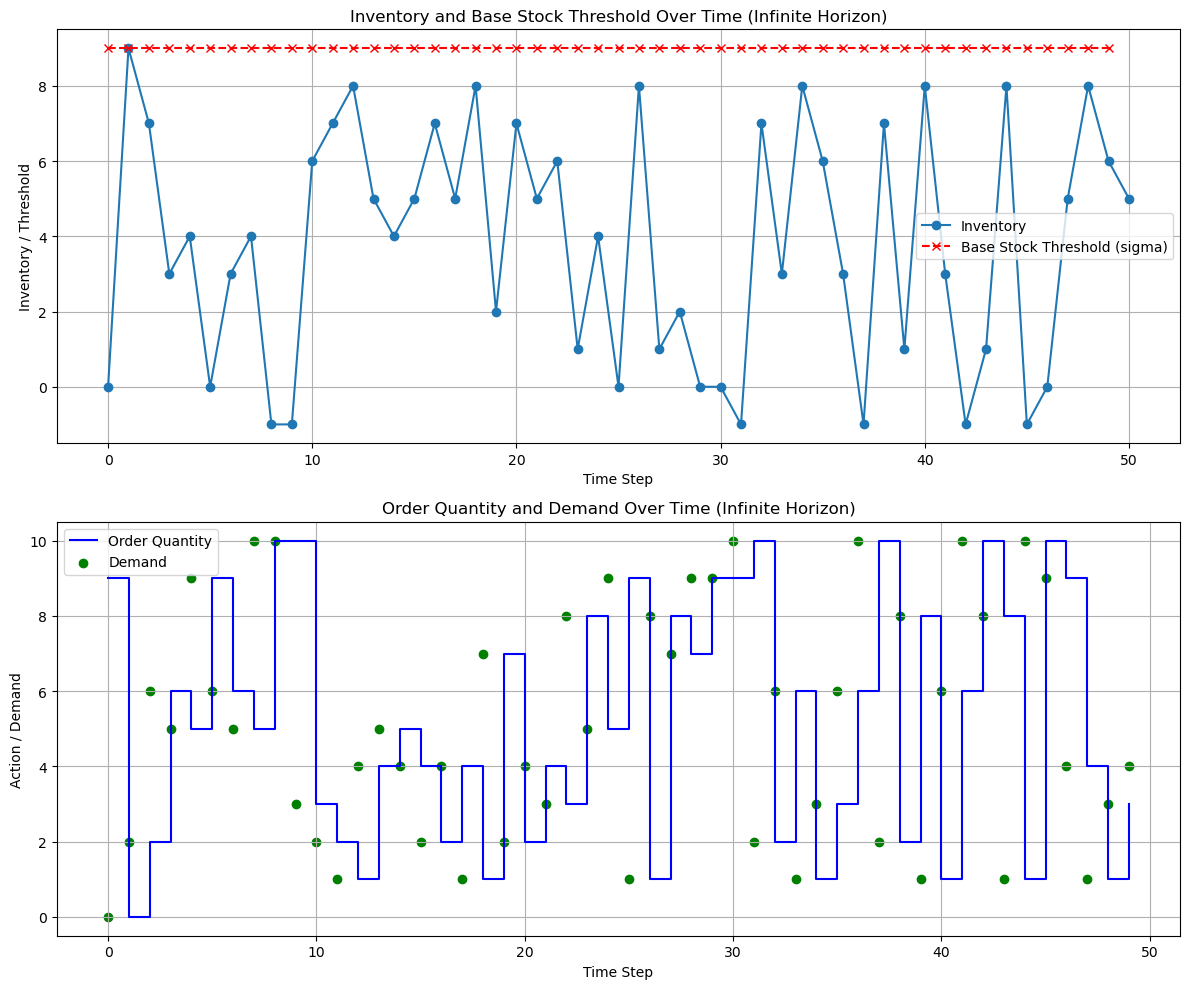

In [30]:
import random
def simulate_and_print_and_plot_infinite(policy, sigma, time_steps):
    """
    Simulate one episode of length time_steps using the stationary infinite-horizon policy.
    Here, the action is taken directly from the stationary policy (policy) derived from VI.
    
    For each time step, print:
      - Current inventory,
      - Base-stock threshold sigma (for reference),
      - Demand,
      - Action (from the policy).
    
    Then, produce two plots:
      1. Inventory vs. time with the constant base-stock threshold line.
      2. Order quantity (action) and demand vs. time.
    """
    current_inventory = 0
    times = []
    inventories = []
    sigma_trace = []
    actions_list = []
    demands = []
    
    print("Time | Inventory |  Base-Stock (sigma) | Demand | Action")
    print("-----------------------------------------------------------")
    for t in range(time_steps):
        state_idx = vi.inventory_to_state(current_inventory)
        action = policy[state_idx]  # Use the stationary policy directly.
        demand = random.randint(0, 10)
        print(f"{t:4d} | {current_inventory:9d} | {sigma:18d} | {demand:6d} | {action:6d}")
        
        times.append(t)
        inventories.append(current_inventory)
        sigma_trace.append(sigma)
        actions_list.append(action)
        demands.append(demand)
        
        new_inventory = current_inventory + action - demand
        new_inventory = max(vi.min_inventory, min(new_inventory, vi.max_inventory))
        current_inventory = new_inventory
    
    times.append(time_steps)
    inventories.append(current_inventory)
    
    plt.figure(figsize=(12, 10))
    
    # Subplot 1: Inventory vs. Base-stock threshold (sigma)
    plt.subplot(2, 1, 1)
    plt.plot(times, inventories, marker='o', linestyle='-', label="Inventory")
    plt.plot(range(time_steps), sigma_trace, marker='x', linestyle='--', color='red', label="Base Stock Threshold (sigma)")
    plt.xlabel("Time Step")
    plt.ylabel("Inventory / Threshold")
    plt.title("Inventory and Base Stock Threshold Over Time (Infinite Horizon)")
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Order Quantity (Action) vs. Demand
    plt.subplot(2, 1, 2)
    plt.step(range(time_steps), actions_list, where='post', label="Order Quantity", color='blue')
    plt.scatter(range(time_steps), demands, label="Demand", color='green')
    plt.xlabel("Time Step")
    plt.ylabel("Action / Demand")
    plt.title("Order Quantity and Demand Over Time (Infinite Horizon)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

########################################
# Run Simulation for Infinite Horizon
########################################
time_steps_sim = 50
# The stationary policy from infinite-horizon VI is stored in vi_inf.policy (1D array, one per state).
policy_infinite = vi.policy  # Use this policy directly.
simulate_and_print_and_plot_infinite(policy_infinite, sigma, time_steps_sim)


In [31]:
for state in range(min_inv, max_inv+1):
    print(f"State {state}, value = {vi.V[vi.inventory_to_state(state)]}")

State -200, value = 8182.411051900647
State -199, value = 8116.3302906896715
State -198, value = 8050.5610641953635
State -197, value = 7985.103596301319
State -196, value = 7919.958110983234
State -195, value = 7855.124832270857
State -194, value = 7790.6039842241225
State -193, value = 7726.395790930219
State -192, value = 7662.5004765252925
State -191, value = 7598.9182652404625
State -190, value = 7535.649381467214
State -189, value = 7472.6940498327685
State -188, value = 7410.052495272903
State -187, value = 7347.724943088292
State -186, value = 7285.711618971451
State -185, value = 7224.012748994751
State -184, value = 7162.6285595558675
State -183, value = 7101.559277284399
State -182, value = 7040.805128921157
State -181, value = 6980.366341188461
State -180, value = 6920.243140674084
State -179, value = 6860.43575375269
State -178, value = 6800.944406565601
State -177, value = 6741.769325071983
State -176, value = 6682.9107351729745
State -175, value = 6624.368862896616
State